# Wealthfront Take-Home

This notebook is a walk through of code solution for the Sr. Data Science interview homework assignment. This notebook is optimized for training. To score in a production environment, the model needs to be stored (pickle, mlflow, etc) and then called for scoring. 

<b>Author:</b> Hannah Jones

<b>Date:</b> 2023-12-02

## Assignment Description

You work for a lending company that provides small loans to individual borrowers for 3 or 5 years. The company has collected data on the loans granted in the past few years. Your responsibility is to conduct an analysis of the data and retrieve key data insights as described below.

| **row_id**               | **Description**                                                              |
|--------------------------|------------------------------------------------------------------------------|
| customer_id              | A unique id for the loan borrower                                            |
| loan_amount              | The amount of the loan requested by the borrower                             |
| funded_amount            | The amount of the loan that was actually provided to the borrower            |
| term                     | The term of the loan                                                         |
| interest_rate            | The interest rate for the loan                                               |
| installment              | The monthly payment                                                          |
| emp_length               | Borrower's length of employment at their last job                            |
| home_owner               | Borrower's home ownership status                                             |
| annual_income            | Borrower's annual income                                                     |
| loan_status              | Status of the loan                                                           |
| purchase                 | Purpose of the loan                                                          |
| addr_state               | Borrower's state of residence                                                |
| dti                      | Borrower's debt to income ratio                                              |
| delinq_2yrs              | The frequency of the borrower's credit delinquencies in the last 2 years     |
| earliest_cr_line         | The date the borrower started his/her first credit line (credit card, etc. ) |
| months_since_last_delinq | The number of months since the borrower was last delinquent on a payment     |
| open_acc                 | The number of the borrower's open credit accounts                            |
| revol_bal                | The borrower's credit card (i.e. revolving credit line) balance              |
| total_accounts           | The number of the borrower's total credit accounts                           |
| outstanding_principal    | Outstanding principal of the loan                                            |
| total_payment            | Total payment on the loan so far                                             |
| total_received_principal | Total principal payments received on the loan so far                         |
| total_received_interest  | Total interest payments received on the loan so far                          |

**Tasks**
1. Implement one or more models to predict whether a loan will be "good" or "bad"
2. Assess the performance of your models, using statistics or charts as necessary
3. Discuss the implications of your work and any insights you have uncovered

## Env Set Up

In [181]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [182]:
# import csv data
df = pd.read_csv("loan_data.csv")
print(df.shape)

(10000, 29)


In [183]:
df.head()

,id,loan_amnt,funded_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,loan_status,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,mths_since_last_delinq,open_acc,revol_bal,total_acc,out_prncp,total_pymnt,total_rec_prncp,total_rec_int,wtd_loans,interest_rate,int_rate2,num_rate,numrate,int_rate3
0,571203,18000,18000,60 months,10.16,383.87,10+ years,MORTGAGE,72804.0,Current,credit_card,MA,16.73,0.0,1995-12-27 02:06:00,NaN,21.0,8751.0,49.0,13263.18,7273.77,4736.82,2536.95,NaN,NaN,10.16%,NaN,NaN,10.16
1,694891,15675,15675,36 months,8.90,497.74,10+ years,MORTGAGE,100000.0,Current,small_business,WA,9.10,0.0,1994-04-07 12:00:00,NaN,16.0,20650.0,45.0,15294.25,496.78,380.75,116.03,NaN,NaN,8.90%,NaN,NaN,8.90
2,784712,16500,16500,60 months,7.90,333.78,2 years,MORTGAGE,42000.0,Late (31-120 days),small_business,NY,10.43,0.0,1993-07-16 08:41:00,NaN,9.0,2229.0,17.0,12966.64,5000.85,3533.36,1467.49,NaN,NaN,7.90%,NaN,NaN,7.90
3,843448,5500,5500,36 months,13.67,187.10,3 years,RENT,55000.0,Fully Paid,debt_consolidation,NJ,20.71,0.0,1987-07-24 12:40:00,NaN,17.0,9486.0,25.0,0.00,5792.14,5500.00,292.14,NaN,NaN,13.67%,NaN,NaN,13.67
4,974654,6400,6400,36 months,15.80,224.38,2 years,RENT,34000.0,Current,debt_consolidation,VA,32.40,0.0,1998-03-15 06:57:00,47.0,6.0,4915.0,15.0,4430.59,2912.26,1969.41,942.85,NaN,NaN,15.80%,NaN,NaN,15.80


In [184]:
df.tail()

,id,loan_amnt,funded_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,loan_status,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,mths_since_last_delinq,open_acc,revol_bal,total_acc,out_prncp,total_pymnt,total_rec_prncp,total_rec_int,wtd_loans,interest_rate,int_rate2,num_rate,numrate,int_rate3
9995,10105778,10000,10000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9996,10109949,15000,15000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9997,10112187,3500,3500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9998,10119897,10000,10000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9999,10123100,4000,4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [185]:
df.isna().sum()

id                            0
loan_amnt                     0
funded_amnt                   0
term                        476
int_rate                    476
installment                 476
emp_length                  881
home_ownership              476
annual_inc                  476
loan_status                 476
purpose                     476
addr_state                    0
dti                         476
delinq_2yrs                 476
earliest_cr_line            476
mths_since_last_delinq     5900
open_acc                    476
revol_bal                   476
total_acc                   476
out_prncp                   476
total_pymnt                 476
total_rec_prncp             476
total_rec_int               476
wtd_loans                 10000
interest_rate             10000
int_rate2                   476
num_rate                  10000
numrate                   10000
int_rate3                   476
dtype: int64

We notice that there are multiple columns with all or signifigant null values. It is important to note that columns like `mths_since_last_delinq` include null values due to the fact that these customers have not been delinquent. However, `wtd_loans`, `interest_rate`, and `num_rate` are completely null and would need to be dropped. 

There are also multiple rows with exactly 476 null values. Upon inspection, there is not enough information to infer from these rows so they need to be dropped.

In [186]:
df = df.dropna(axis=1, how='all')

In [187]:
# drop cols with 476 nulls
# print(df.isna().sum(axis=1).value_counts())
df = df.dropna(thresh=20)
print(f"Final dataframe {df.shape}")

Final dataframe (9524, 25)


## Target Creation
A target is considered "bad" if it is in **Default** or **Charged Off**. 

In [188]:
df['target'] = df['loan_status'].apply(lambda x: 1 if x == 'Default' or x == 'Charged Off' else 0)
df = df.drop(columns='loan_status')
df.target.value_counts(normalize=True)
print(f"Bad Loan rate: {df.target.mean():.2%}")

Bad Loan rate: 2.46%


## Exploratory Data Analysis

### Evaluate categorical variables

In [189]:
# cat_cols = df.select_dtypes(exclude='number').columns
# print(cat_cols)
# for col in cat_cols:
#     print(df[col].value_counts())
#     print('-'*30)

For the categorical values I will make the following changes to make them more efficient for processing and easier to gain insights from.

* `term`: One-hot encode where 0 = 36 months, 1 = 60 months
* `emp_length`: Convert to integer
* `home_ownership`: None
* `loan_status`: None
* `earliest_cr_line`: Convert to year (ideally, i would like to explore the lift between using the entire date versus only the year)
* `int_rate2`: Convert to percentage from string

In [190]:
# term 
term_label_encoder = LabelEncoder()
df['term'] = term_label_encoder.fit_transform(df['term']) # 60 > 30, 1 > 0

In [191]:
# emp_length
df['emp_length'] = df['emp_length'].str.replace('< 1 year', '0')
df['emp_length'] = df['emp_length'].str.extract(r'([0-9]*)')

In [192]:
# earliest_cr_line
max(df['earliest_cr_line'].str.extract(r'([0-9]{4})')[0])
df['earliest_cr_line'] = df['earliest_cr_line'].str.extract(r'([0-9]{4})').astype(int)

In [193]:
df['int_rate2'] = df['int_rate2'].str.extract(r'([0-9]*.[0-9]*)')
df['int_rate2'] = df['int_rate2'].astype(float)

I notice some odd years as someones first line of credit, which are outliers. These rows may need to be removed.

### Evaluate numerical columns

In [194]:
num_cols = df.select_dtypes('number').columns
num_cols = num_cols[1:len(num_cols)]

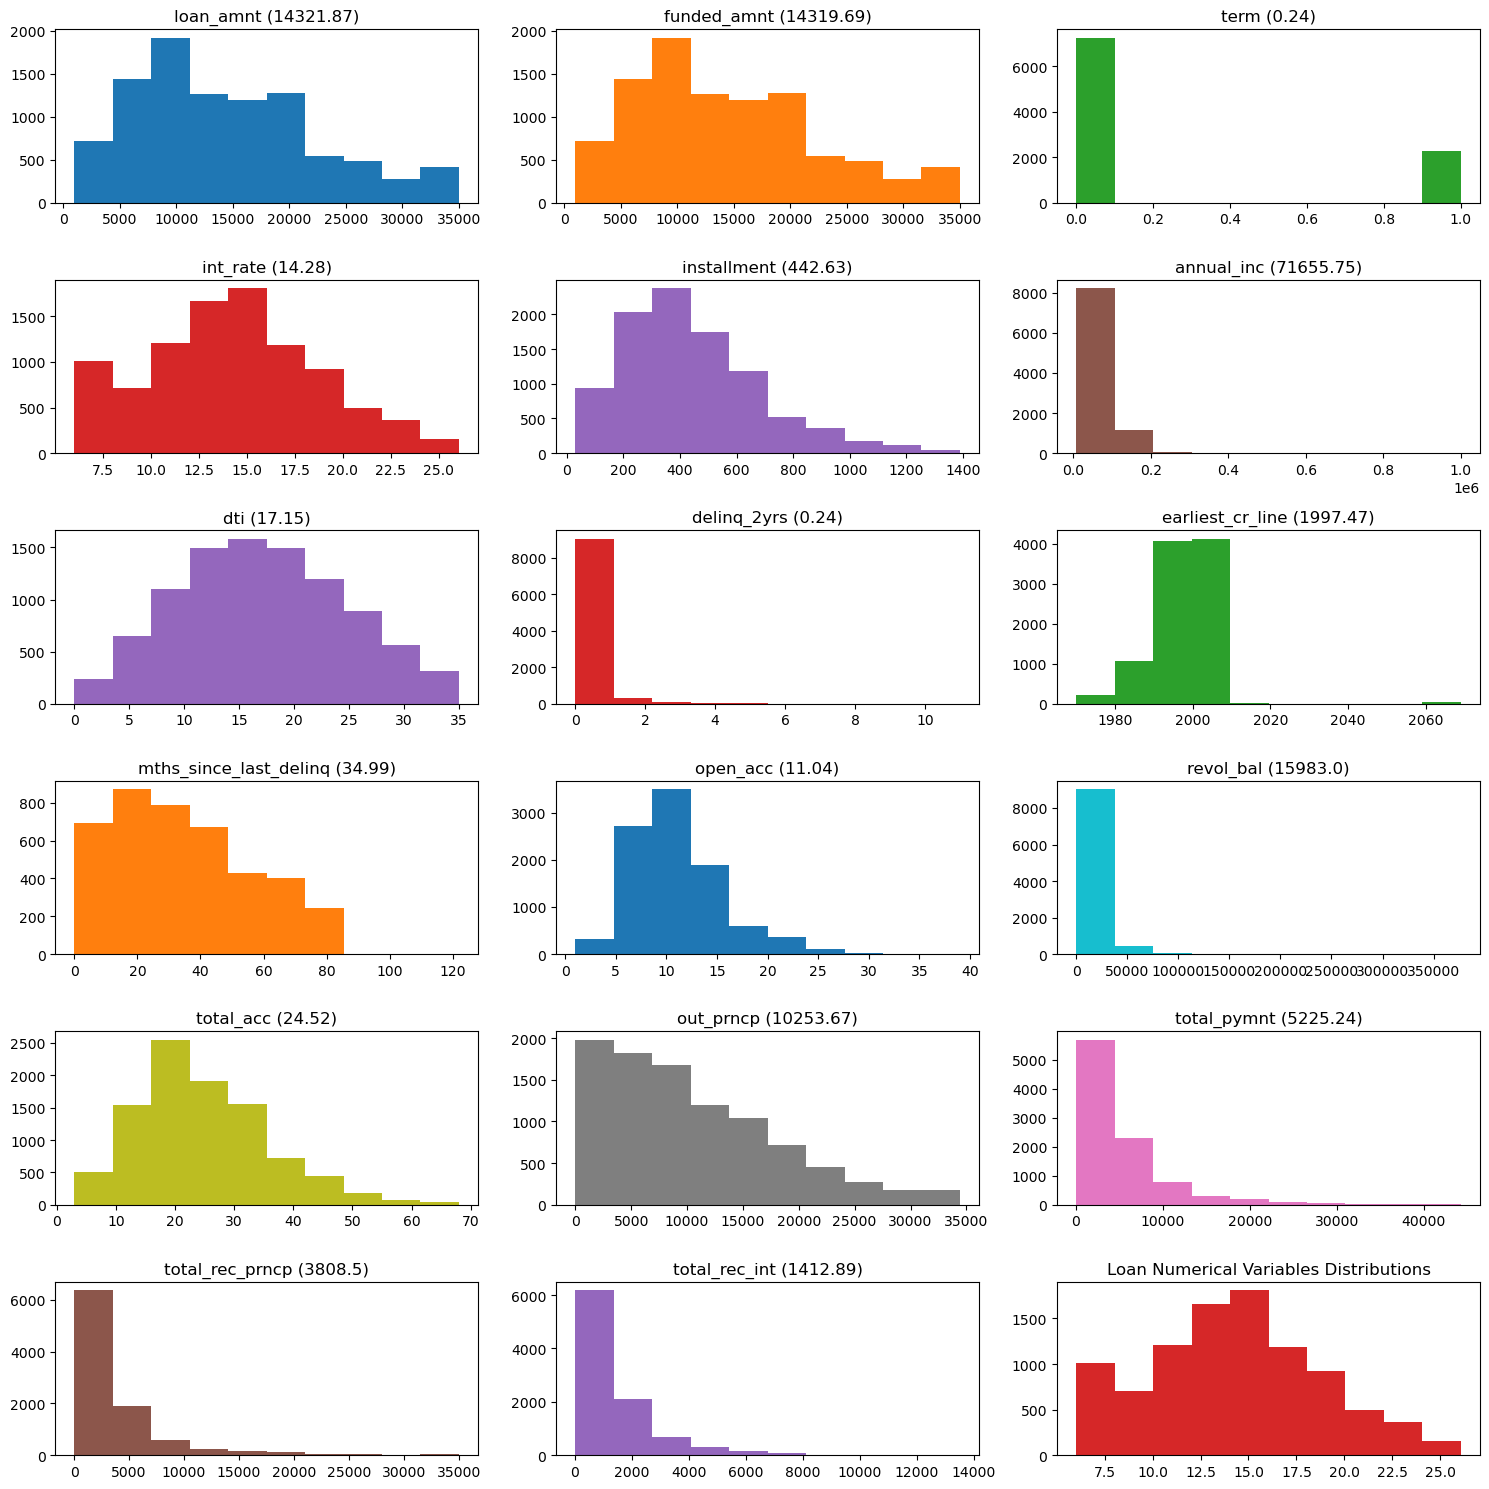

In [195]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

rows = 6
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
colors = list(mcolors.TABLEAU_COLORS.values())

axes = axes.flatten()

for i in range(rows*cols):
    axes[i].hist(df[num_cols[i]], color=colors[min(10-i,i)])
    axes[i].set_title(f'{num_cols[i]} ({round(df[num_cols[i]].mean(),2)})')

plt.title("Loan Numerical Variables Distributions")
    
plt.tight_layout()

plt.show()

Its important to note not all the columns are in the data dictionary. (`int_rate2`, `int_rate3`)

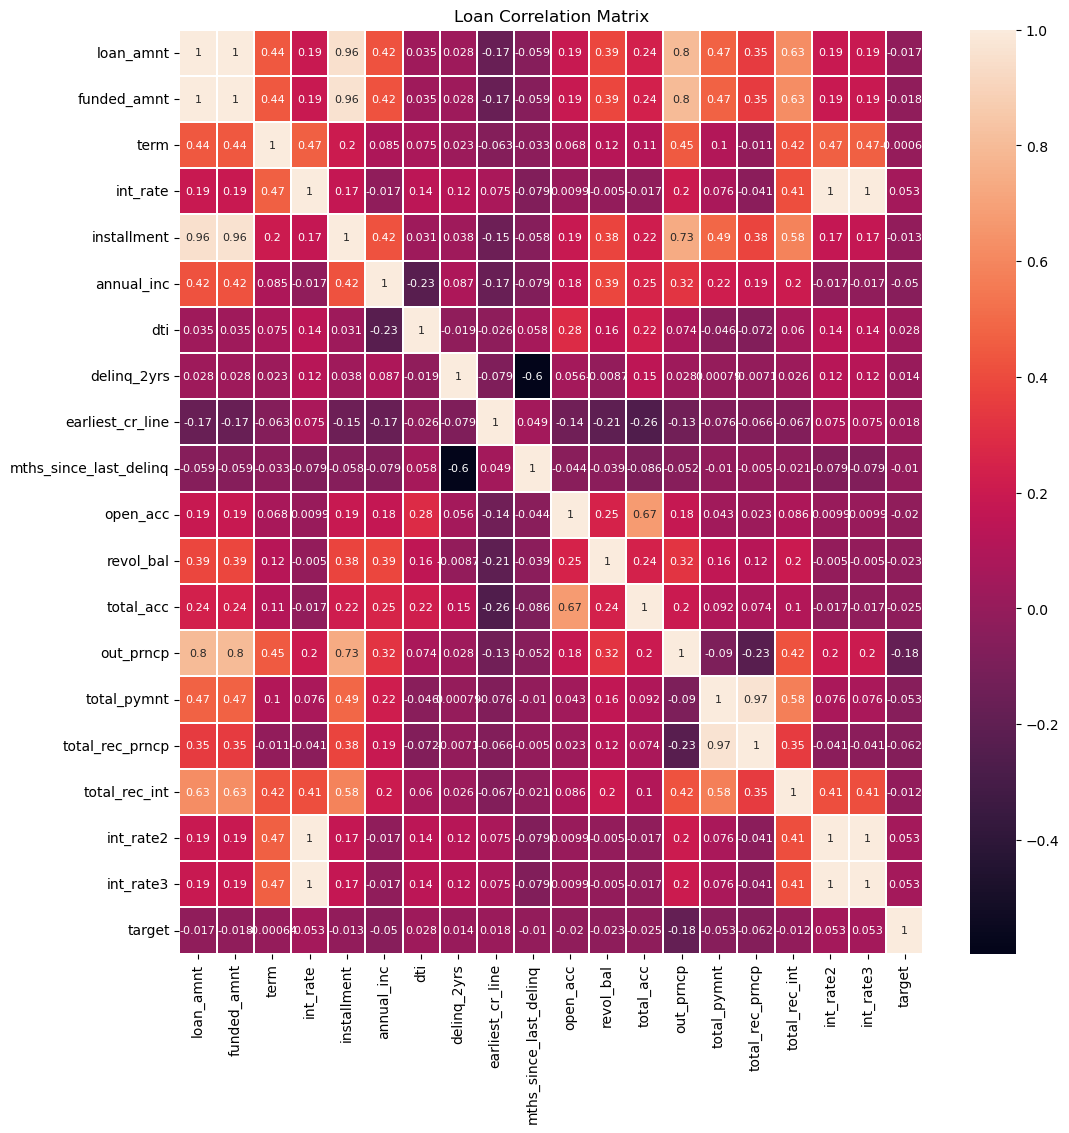

In [196]:
# Correlation Matrix
plt.figure(figsize=(12, 12))

sns.heatmap(df[num_cols].corr(), annot=True, linewidths=.1, annot_kws={"size": 8})

plt.title("Loan Correlation Matrix")

plt.show()

We see multiple variables that suffer from extreme collinearity. 

1. `int_rate`, `int_rate2`, `int_rate3`
2. `loan_amnt`, `funded_amnt`

Due to these features correlations, I will drop all but one from each group. 

Fortunately, we observe no columns have an extremely high correlation with our target.

In [197]:
df = df.drop(columns=['int_rate2','int_rate3','funded_amnt','id'])

In [198]:
print(df.shape)
df.head()

(9524, 21)


,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,mths_since_last_delinq,open_acc,revol_bal,total_acc,out_prncp,total_pymnt,total_rec_prncp,total_rec_int,target
0,18000,1,10.16,383.87,10,MORTGAGE,72804.0,credit_card,MA,16.73,0.0,1995,NaN,21.0,8751.0,49.0,13263.18,7273.77,4736.82,2536.95,0
1,15675,0,8.90,497.74,10,MORTGAGE,100000.0,small_business,WA,9.10,0.0,1994,NaN,16.0,20650.0,45.0,15294.25,496.78,380.75,116.03,0
2,16500,1,7.90,333.78,2,MORTGAGE,42000.0,small_business,NY,10.43,0.0,1993,NaN,9.0,2229.0,17.0,12966.64,5000.85,3533.36,1467.49,0
3,5500,0,13.67,187.10,3,RENT,55000.0,debt_consolidation,NJ,20.71,0.0,1987,NaN,17.0,9486.0,25.0,0.00,5792.14,5500.00,292.14,0
4,6400,0,15.80,224.38,2,RENT,34000.0,debt_consolidation,VA,32.40,0.0,1998,47.0,6.0,4915.0,15.0,4430.59,2912.26,1969.41,942.85,0


I am not going to futher exhaust EDA on the independing variables at this point.

# Models

I will explore two models to determine whether a customers loan is "good" or "bad". 

1. XGBoost
2. Catboost

I will go into detail on the successes and pitfalls of using these two methods in a production setting and given more time, the other models I would explore. 

## Training

<a href="https://catboost.ai/en/docs/installation/python-installation-method-build-a-wheel-package">"Build Wheel"

In [199]:
!pip install shap

In [200]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

import catboost as cb
from catboost import Pool, CatBoostClassifier

import xgboost as xgb

import shap 

In [201]:
TARGET_COL = 'target'

### Catboost

In [202]:
d_train, d_test = train_test_split(df, test_size=0.2, random_state=42)
print(f"Training: {d_train.shape}, Test: {d_test.shape}")

Training: (7619, 21), Test: (1905, 21)


In [203]:
params = {
    'random_seed': 12,
    'loss_function':'Logloss',
    'depth': 5,
    'metric_period': 100,
    'iterations': 500,
    'learning_rate': 0.1,
    'use_best_model': True,
    'od_type':'Iter',
    'od_wait':200,
#     'auto_class_weights':True,
}

In [204]:
# prepare data
cat_cols = [c for c in d_train.columns if d_train[c].dtype == 'object']
d_train[cat_cols] = d_train[cat_cols].fillna('NA')
d_train[cat_cols] = d_train[cat_cols].apply(lambda c: c.str.strip())

# split data
train, val = train_test_split(d_train, test_size=0.1)
y_train = train.pop(TARGET_COL)
y_val = val.pop(TARGET_COL)
val_set = Pool(data=val, label=y_val, cat_features=cat_cols)

model = CatBoostClassifier(**params)
model.fit(train, y_train, eval_set=val_set, cat_features=cat_cols, verbose=True)

0:	learn: 0.5269127	test: 0.5285347	best: 0.5285347 (0)	total: 6.13ms	remaining: 3.06s


100:	learn: 0.0096223	test: 0.0116181	best: 0.0112449 (69)	total: 661ms	remaining: 2.61s
200:	learn: 0.0046716	test: 0.0113725	best: 0.0111368 (154)	total: 1.53s	remaining: 2.28s
300:	learn: 0.0024010	test: 0.0110295	best: 0.0109696 (298)	total: 2.38s	remaining: 1.57s
400:	learn: 0.0016133	test: 0.0114280	best: 0.0109696 (298)	total: 3.04s	remaining: 752ms
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.01096958991
bestIteration = 298

Shrink model to first 299 iterations.


### Model Evaluation

In [205]:
test_full = d_test.copy()
test = d_test[[c for c in d_test.columns if c != TARGET_COL]]

In [206]:
cat_cols = [c for c in test.columns if df[c].dtype == 'object']
test[cat_cols] = test[cat_cols].fillna('NA')
test[cat_cols] = test[cat_cols].apply(lambda c: c.str.strip())


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [207]:
threshold = 0.5

In [208]:
probs = model.predict_proba(Pool(data=test, cat_features=cat_cols))[:,1]
pred_class = probs > threshold
pred_class = pred_class.astype(int)
test_full['pred_class'] = pred_class

y_true = test_full[TARGET_COL]
y_pred = test_full['pred_class']

In [210]:
print(f"True Bad Loan Rate: {test_full[TARGET_COL].mean()}")
print(f"Predicted Bad Loan Rate: {test_full['pred_class'].mean()}")

True Bad Loan Rate: 0.028346456692913385
Predicted Bad Loan Rate: 0.025721784776902887


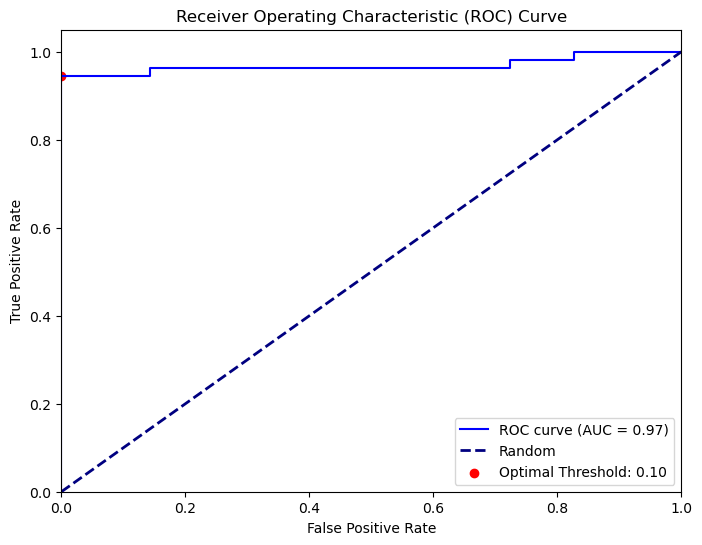

In [211]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

fpr, tpr, thresholds = roc_curve(y_true, probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color = 'blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

i = np.argmax(tpr-fpr)
optimal_threshold = thresholds[np.argmax(tpr-fpr)]
plt.scatter(fpr[i], tpr[i], c='red', marker='o', label=f"Optimal Threshold: {optimal_threshold:.2f}")
plt.legend(loc='best')

plt.show()

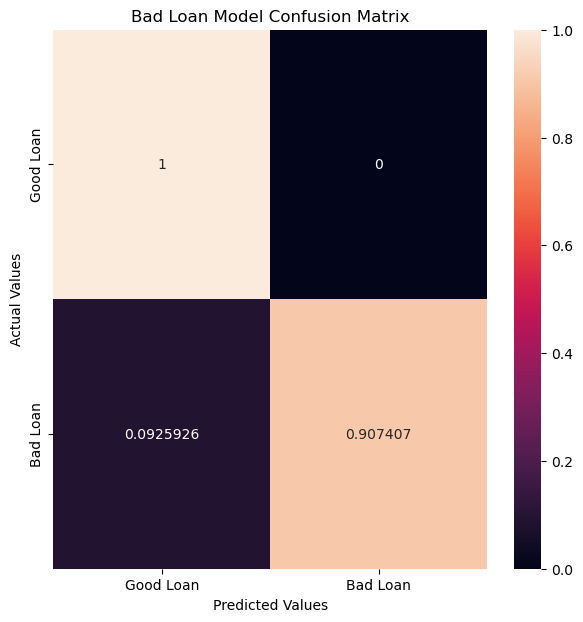

In [230]:
labels = ['Good Loan','Bad Loan']
cm = metrics.confusion_matrix(y_true, y_pred,normalize='true')
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(7,7))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title(f'Bad Loan Model Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [215]:
metrics.precision_score(y_true, y_pred)

1.0

In [216]:
metrics.recall_score(y_true, y_pred)

0.9074074074074074

In [217]:
metrics.f1_score(y_true, y_pred)

0.9514563106796117

In [218]:
metrics.accuracy_score(y_true, y_pred)

0.9973753280839895

In [224]:
cm_df.loc['Bad Loan'][1] / cm_df['Bad Loan'].sum()

0.9074074074074074

In [234]:
set1 = set(list(train.index))
set2 = set(list(test.index))

list(set1.intersection(set2))

[]

## Model Explainability

In [235]:
explainer = shap.TreeExplainer(model)
shap_obj = explainer(test)
shap_values = explainer.shap_values(test)

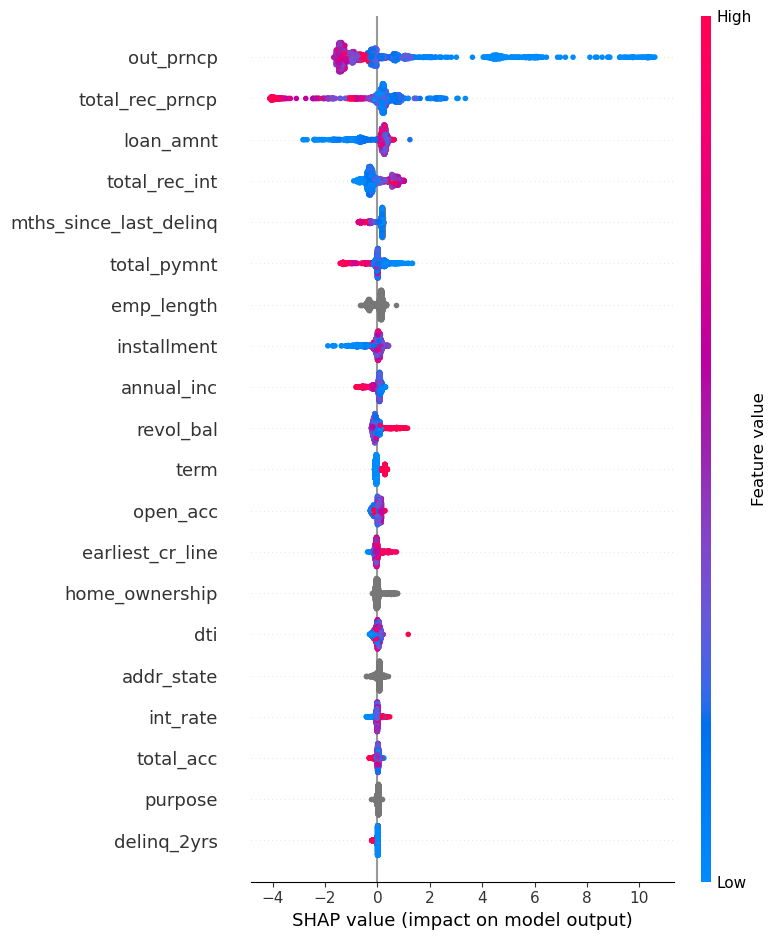

In [236]:
shap.summary_plot(shap_values, test.values, feature_names = test.columns)

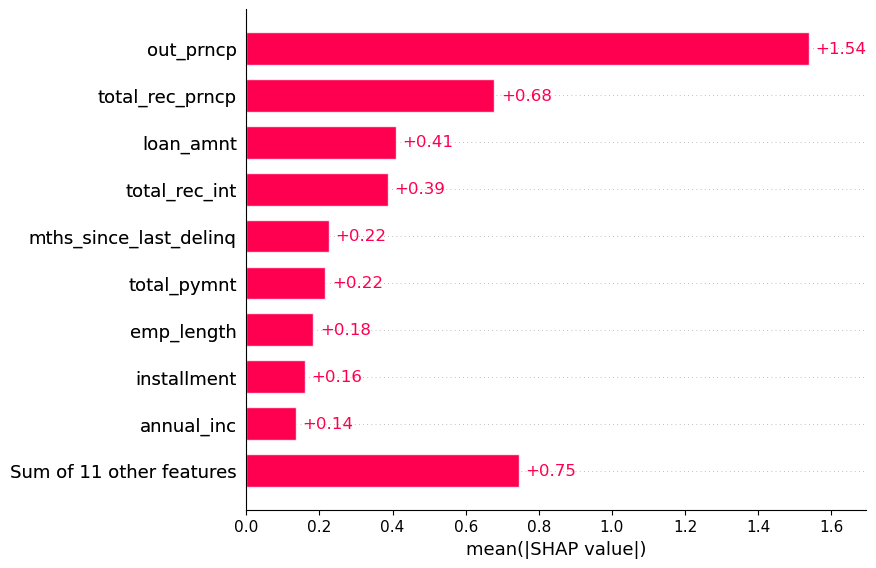

In [240]:
shap.plots.bar(shap_obj)